# Experiment: the effect of data imbalance on the performance of a classifier

There is high label imbalance in capstone project 1 (CP01). The purpose of this experiment is to investigate and show the effect of data imbalance on various performance metrics such as accuracy and precision. The dataset used in this experiment consists of gender (male/female), height and weight. The classifier is trained on height and weight data with the objective of predict the gender given any height/weight data. <br> <br> The original dataset consisted of 5,000 male and 5,000 female data records. The capstone project has a positive to negative label ratio of 1:228. To mimic the imbalance, I removed 4,978 female data. The performance metrics from the original dataset and the imbalanced data are compared to investigate the effect of data imbalance on the predictions of the classifier.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import sklearn.model_selection

Load the imbalanced dataset including the proxy features (5,000 males and 22 females).

In [2]:
dflog_imbalanced = pd.read_csv("data/new_list2")
dflog_imbalanced.head()

,Gender,Height,Weight,FirstPerson
0,Male,73.847017,241.893563,Adam
1,Male,68.781904,162.310473,Adam
2,Male,74.110105,212.740856,Adam
3,Male,71.730978,220.042470,Adam
4,Male,69.881796,206.349801,Adam


Load the complete dataset (5,000 males and 5,000 females)

In [3]:
dflog_orig = pd.read_csv("data/new_list")
dflog_orig.head()

,Gender,Height,Weight,FirstPerson
0,Male,73.847017,241.893563,Adam
1,Male,68.781904,162.310473,Adam
2,Male,74.110105,212.740856,Adam
3,Male,71.730978,220.042470,Adam
4,Male,69.881796,206.349801,Adam


Lets double-check the size of both datasets.

In [4]:
print(dflog_imbalanced.shape,dflog_orig.shape)

(5022, 4) (10000, 4)


Plot the weight and height of both males and females from the complete dataset to show the linear relationship between height and weight.

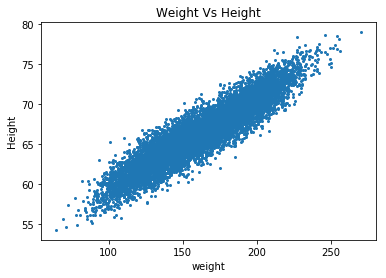

In [5]:
plt.scatter(dflog_orig.Weight, dflog_orig.Height,s=4);
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Weight Vs Height')

Plot height/weight of males and females using different colors.

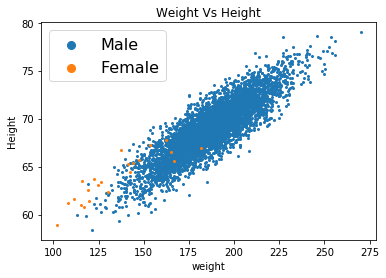

In [6]:
plt.scatter(dflog_imbalanced[dflog_imbalanced.Gender=='Male'].Weight, dflog_imbalanced[dflog_imbalanced.Gender=='Male'].Height,s=4,label='Male');
plt.scatter(dflog_imbalanced[dflog_imbalanced.Gender=='Female'].Weight, dflog_imbalanced[dflog_imbalanced.Gender=='Female'].Height,s=4,label='Female');
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Weight Vs Height')
plt.legend(fontsize=16,markerscale=4)

The figure above shows the high imbalance in the dataset that mimics the imbalance in the infant natality/fatality dataset.

Let's look at the features.

In [7]:
list(dflog_imbalanced.columns)

['Gender', 'Height', 'Weight', 'FirstPerson']

In [8]:
list(dflog_orig.columns)

['Gender', 'Height', 'Weight', 'FirstPerson']

The following function takes regularization parameters, train set, test set, and nfolds and returns the best classifier. 

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

The following function splits dataset into train and test sets and uses the function defined above (cv_optimize) to use the best estimator and returns the train/test datasets, the classifier and prints the performance of the classifier.

In [10]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

## 1. Predictor using the imbalanced dataset

In [11]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog_imbalanced, ['Weight', 'Height'], 'Gender','Female')

BEST PARAMS {'C': 0.1}
Accuracy on training data: 1.00
Accuracy on test data:     1.00


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The results show accuracy of 1.00 for both training/test datasets.

In [13]:
print("The coefficients for weight and height are {:.3f}, and {:.3f} respectively. ".format
      (clf_l.coef_[0,0], clf_l.coef_[0,1]))

The coefficients for weight and height are -0.160, and 0.309 respectively. 


Lets print out the size of the training/test set predictors and training/test set target features:

In [14]:
print(Xtrain_l.shape, ytrain_l.shape, Xtest_l.shape, ytest_l.shape)

(4017, 2) (4017,) (1005, 2) (1005,)


In [15]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

In [16]:
print("The number of records in the training data set and test data set are {} and {} respectively.".format(
    SS_train,SS_test))
print("The proportion of positive and negative labels in the training data set are {} and {} respectively.".format(
    PP_train,NP_train))
print("The proportion of positive and negative labels in the test data set are {} and {} respectively.".format(
    PP_test,NP_test))

The number of records in the training data set and test data set are 4017 and 1005 respectively.
The proportion of positive and negative labels in the training data set are 0.005 and 0.995 respectively.
The proportion of positive and negative labels in the test data set are 0.003 and 0.997 respectively.


The following extracts the confusion matrix of the test dataset to compute the various performance metrics.

In [17]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cm_test = pd.DataFrame(cm_test)

[[1002    0]
 [   3    0]]


In [18]:
TN_test = cm_test[0][0];TP_test = cm_test[1][1];FP_test = cm_test[0][1]; FN_test = cm_test[1][0]

In [19]:
print("The number of true negative, true positive, false positive, and false negative in the test dataset are {}, {}, {} and {} respectively.".format(
    TN_test, TP_test, FP_test, FN_test))

The number of true negative, true positive, false positive, and false negative in the test dataset are 1002, 0, 3 and 0 respectively.


In [20]:
TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


The following extracts the confusion matrix of the training dataset to compute the various performance metrics.

In [21]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l))
print(cm_train)
cm_train = pd.DataFrame(cm_train)

[[3996    2]
 [  11    8]]


In [22]:
TN_train = cm_train[0][0];TP_train = cm_train[1][1];FP_train = cm_train[0][1]; FN_train = cm_train[1][0]

In [23]:
print("The number of true negative, true positive, false positive, and false negative in the training dataset are {}, {}, {} and {} respectively.".format(
    TN_train, TP_train, FP_train, FN_train))

The number of true negative, true positive, false positive, and false negative in the training dataset are 3996, 8, 11 and 2 respectively.


In [24]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

#### Performance Table

In [25]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [26]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [27]:
#PP: Proportion of positive labels
#NP: Proportion of negative labels
#SS: Total number of records
#TNR: Total negative rate
performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.005,0.995,4017,0.997,0.421,0.8,0.997
Test Set,0.003,0.997,1005,0.997,0.0,nan,0.997


## 2. Predictor using the the complete balanced dataset

In [28]:
clf_l_o, Xtrain_l_o, ytrain_l_o, Xtest_l_o, ytest_l_o  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog_orig, ['Weight', 'Height'], 'Gender','Female')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 1}
Accuracy on training data: 0.92
Accuracy on test data:     0.93


The results show accuracy of 0.92/0.93 for the training and test datasets respectively.

In [30]:
print("The coefficients for weight and height are {:.3f}, and {:.3f} respectively. ".format
      (clf_l_o.coef_[0,0], clf_l_o.coef_[0,1]))

The coefficients for weight and height are -0.196, and 0.475 respectively. 


In [31]:
SS_train_o = Xtrain_l_o.shape[0] 
SS_test_o = Xtest_l_o.shape[0]
PP_train_o = round(np.sum(ytrain_l_o)/SS_train_o,3)
NP_train_o = round(np.sum(ytrain_l_o == 0)/SS_train_o,3)
PP_test_o = round(np.sum(ytest_l_o)/SS_test_o,3)
NP_test_o = round(np.sum(ytest_l_o == 0)/SS_test_o,3)

Lets print out the size of the training/test set predictors and training/test set target features:

In [32]:
print(Xtrain_l_o.shape, ytrain_l_o.shape, Xtest_l_o.shape, ytest_l_o.shape)

(8000, 2) (8000,) (2000, 2) (2000,)


In [33]:
print("The number of records in the training data set and test data set are {} and {} respectively.".format(
    SS_train_o,SS_test_o))
print("The proportion of positive and negative labels in the training data set are {} and {} respectively.".format(
    PP_train_o,NP_train_o))
print("The proportion of positive and negative labels in the test data set are {} and {} respectively.".format(
    PP_test_o,NP_test_o))

The number of records in the training data set and test data set are 8000 and 2000 respectively.
The proportion of positive and negative labels in the training data set are 0.498 and 0.502 respectively.
The proportion of positive and negative labels in the test data set are 0.508 and 0.492 respectively.


The following extracts the confusion matrix of the test dataset to compute the various performance metrics.

In [34]:
from sklearn.metrics import confusion_matrix
cm_test_o = confusion_matrix(ytest_l_o,clf_l_o.predict(Xtest_l_o))
print(cm_test_o)
cm_test_o = pd.DataFrame(cm_test_o)

[[912  71]
 [ 79 938]]


In [35]:
TN_test_o = cm_test_o[0][0];TP_test_o = cm_test_o[1][1];FP_test_o = cm_test_o[0][1]; FN_test_o = cm_test_o[1][0]

In [36]:
print("The number of true negative, true positive, false positive, and false negative in the test dataset are {}, {}, {} and {} respectively.".format(
    TN_test_o, TP_test_o, FP_test_o, FN_test_o))

The number of true negative, true positive, false positive, and false negative in the test dataset are 912, 938, 79 and 71 respectively.


In [37]:
TPR_test_o = round(TP_test_o/(TP_test_o+FN_test_o),3) #true positive rate (Recall)

TNR_test_o = round(TN_test_o/(TN_test_o+FP_test_o),3) #true negative rate (Specifity)

PPV_test_o = round(TP_test_o/(TP_test_o+FP_test_o),3) #positive predictive value (Precision)

NPV_test_o = round(TN_test_o/(TN_test_o+FN_test_o),3) # Negative predictive value

FPR_test_o = round(FP_test_o/(FP_test_o+TN_test_o),3) # Fall out or false positive rate

FNR_test_o = round(FN_test_o/(TP_test_o+FN_test_o),3) # False negative rate

FDR_test_o = round(FP_test_o/(TP_test_o+FP_test_o),3) # False discovery rate

ACC_test_o = round((TP_test_o+TN_test_o)/(TP_test_o+FP_test_o+FN_test_o+TN_test_o),3) # Overall accuracy

The following extracts the confusion matrix of the training dataset to compute the various performance metrics.

In [38]:
from sklearn.metrics import confusion_matrix
cm_train_o = confusion_matrix(ytrain_l_o,clf_l_o.predict(Xtrain_l_o))
print(cm_train_o)
cm_train_o = pd.DataFrame(cm_train_o)

[[3692  325]
 [ 330 3653]]


In [39]:
TN_train_o = cm_train_o[0][0];TP_train_o = cm_train_o[1][1];FP_train_o = cm_train_o[0][1]; FN_train_o = cm_train_o[1][0]

In [40]:
print("The number of true negative, true positive, false positive, and false negative in the training dataset are {}, {}, {} and {} respectively.".format(
    TN_train_o, TP_train_o, FP_train_o, FN_train_o))

The number of true negative, true positive, false positive, and false negative in the training dataset are 3692, 3653, 330 and 325 respectively.


In [41]:
TPR_train_o = round(TP_train_o/(TP_train_o+FN_train_o),3) #true positive rate (Recall)

TNR_train_o = round(TN_train_o/(TN_train_o+FP_train_o),3) #true negative rate (Specifity)

PPV_train_o = round(TP_train_o/(TP_train_o+FP_train_o),3) #positive predictive value (Precision)

NPV_train_o = round(TN_train_o/(TN_train_o+FN_train_o),3) # Negative predictive value

FPR_train_o = round(FP_train_o/(FP_train_o+TN_train_o),3) # Fall out or false positive rate

FNR_train_o = round(FN_train_o/(TP_train_o+FN_train_o),3) # False negative rate

FDR_train_o = round(FP_train_o/(TP_train_o+FP_train_o),3) # False discovery rate

ACC_train_o = round((TP_train_o+TN_train_o)/(TP_train_o+FP_train_o+FN_train_o+TN_train_o),3) # Overall accuracy

#### Performance Table

In [42]:
performance_data_o = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train_o,NP_train_o,SS_train_o,ACC_train_o,PPV_train_o,TPR_train_o,TNR_train_o],
                             ['Test Set',PP_test_o,NP_test_o,SS_test_o,ACC_test_o,PPV_test_o,TPR_test_o,TNR_test_o]])

In [43]:
performance_table_o = pd.DataFrame(data=performance_data_o[1:,1:],
                      index=performance_data_o[1:,0],
                      columns=performance_data_o[0,1:])

In [44]:
#PP: Proportion of positive labels
#NP: Proportion of negative labels
#SS: Total number of records
#TNR: Total negative rate
performance_table_o

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.498,0.502,8000,0.918,0.917,0.918,0.918
Test Set,0.508,0.492,2000,0.925,0.922,0.93,0.92
